# Homework 2 - Data from the web

### Table of Contents

* [1 - Top Universities](#1)
    * [1.a - Best faculty members/student ratio](#1.a)
    * [1.b - Best in terms of international students](#1.b)
    * [1.c - By coutry](#1.c)
    * [1.d - By region](#1.d)
    
* [2 - Times](#2)
    * [2.a - Best faculty members/student ratio](#2.a)
    * [2.b - Best in terms of international students](#2.b)
    * [2.c - By coutry](#2.c)
    * [2.d - By region](#2.d)
    
* [3 - Merging](#3)
    * [3.1 - Matching school names](#3.1)
        * [3.1.1 - Cleaning the names](#3.1.1)
        * [3.1.2 - Automatic Matching](#3.1.2)
        * [3.1.3 - Manual Matching](#3.1.3)
    * [3.2 - Merging dataframes](#3.2)
    
* [4 - Exploratory analysis](#4)
    * [4.1 - Does university size influence internationality rate ?](#4.1)
    * [4.2 - Does university size influence ranking ?](#4.2)
    * [4.3 - Are european universities more international than other regions ?](#4.3)
    * [4.4 - Do english speaking countries get more international students than others ?](#4.4)
    * [4.5 - Do international students influence ranking ?](#4.5)
    
* [5 - Ranking according to both](#5)
    

### Useful Imports

In [2]:
# Import libraries
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import sys
import time
import re
import pickle

# those two packages must be installed using:
# ```conda install -c bioconda editdistance```
# ```conda install -c anaconda unidecode```
import editdistance
from unidecode import unidecode

from IPython.display import clear_output

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

## 1 - Top Universities <a class="anchor" id="first"></a>

In [3]:
ROOT_URL_TOP_UNIV = "https://www.topuniversities.com/"

In [4]:
def progress(count, total, suffix=''):
    """ Shows the progress of a given action 
    
    @params:
    - count : the current count of done operations
    - total : the total number of operation to do
    - suffix : a message printed after the progress bar
    """
    
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ... %s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()  # As suggested by Rom Ruben

In [5]:
def get_number(enclosing_class_name,url,det_soup):
    """Tries to extract the number we look for. Will return a NaN 
    if the details page doesn't contain such a number
    
    @params:
    - enclosing_class_name : the class of the div into which the number is contained.
    - url : the suffix url of the school (to print an error if not found)
    - det_soup : the soup of the details page for the given school
    
    """
    try:
        n = det_soup.find("div",class_=enclosing_class_name).find("div",class_="number").text.strip('\n')
    except(AttributeError) as e:
        print("Couldn't find '{}' for {}".format(enclosing_class_name,url))
        n = 'NAN'
    return n

def get_details(url):
    """Finds the detail of a given university on the details page
    
    @params:
    - url : the suffix url of the universirty of interest
    
    """
    details_url = ROOT_URL_TOP_UNIV + url
    det_request = requests.get(details_url)
    det_soup = BeautifulSoup(det_request.text, 'lxml')
    labels = ['total faculty','inter faculty','total student','total inter']

    staff_total,staff_inter,student_total,student_inter = [get_number(label,url,det_soup) for label in labels]
    
    return staff_total,staff_inter,student_total,student_inter

In [6]:
def get_ranking_topUni(path_to_dump):
    """
    Will return a dataframe containing the data of the 200 best universities in the rankings published on www.topuniversities.com.
    (in order to minimize the internet traffic every time the notebook is ran, the data is serialized using pickle)
    
    @params:
    - path_to_dump : path were the dump of the data should be (will use it if already present and save there otherwise)
    """
    r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508057903494')
    if(os.path.isfile(path_to_dump)):
        return pd.read_pickle(path_to_dump)

    top_200 = []

    for (i,uni_dict) in enumerate(r.json()['data']):
        if(i>=200):
            break

        title = uni_dict['title']
        rank = uni_dict['rank_display']
        country = uni_dict['country']
        region = uni_dict['region']
        url = uni_dict['url']

        # In case of tie, the rank is prefixed with an '=', we get rid of it.
        rank = rank.strip('=')

        # We then get the details from the details page
        staff_total,staff_inter,student_total,student_inter = get_details(url)
        progress(i+1,200,'Scraping the info')

        top_200.append({'school_name': title, 
                        'rank': rank,
                        'total_staff': staff_total,
                        'international_staff': staff_inter,
                        'total_student': student_total,
                        'international_student': student_inter,
                        'country': country,
                        'region': region
                       })
            
    df = pd.DataFrame.from_dict(top_200)
    
    # We set Rank as an index
    df.set_index('rank',inplace=True)
    
    # Then we convert the number columns to integers
    cols = ['total_staff','international_staff','total_student','international_student']
    df[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str)
                                                       .str.replace(',',''), errors='coerce',downcast='integer'))
    
    # Reorder the df columns for better output
    df = df[['school_name', 'total_staff', 'international_staff', 'total_student', 'international_student', 'country', 'region']]
    
    # We serialize it using pickle so that we do not have to download it again
    df.to_pickle(path_to_dump)
    return df

In [7]:
df_topUni = get_ranking_topUni('topuniversities_backup')
df_topUni.tail(7)

,school_name,total_staff,international_staff,total_student,international_student,country,region
rank,,,,,,,
192,Keio University,3905.0,261.0,33500.0,2178.0,Japan,Asia
195,Stockholm University,2154.0,646.0,28281.0,2636.0,Sweden,Europe
195,Universitat Autònoma de Barcelona,2187.0,230.0,31986.0,3848.0,Spain,Europe
195,Texas A&M University,3446.0,206.0,60294.0,4900.0,United States,North America
199,Instituto Tecnológico y de Estudios Superiores...,1822.0,821.0,13376.0,1412.0,Mexico,Latin America
200,Maastricht University,1277.0,502.0,16385.0,8234.0,Netherlands,Europe
201,Universidad de Chile,2256.0,127.0,38848.0,2134.0,Chile,Latin America


** Remark: there is a mistake in the data,** if we take 200 rows of school we obtain the last school having rank 201. Indeed there is a mistake, looking at the data from Keio University which is at rank 192, if we count the ranks then "Instituto Tecnologico [...]" should be at rank 198 and not 199.

### 1.a - Best university in terms of ratio faculty members over students <a class="anchor" id="1.a"></a>

In order to determine which is the best university regarding ratio between faculty members and students, we create a new column called ```Fac/stud ratio```. Then we sort the rows according to values in this column. (because we were asked for the best universities we display the ranking according to this value)

In [8]:
df_topUni['fac_stud_ratio'] = df_topUni['total_staff']/df_topUni['total_student']
sorted_by_facStudRatio = df_topUni.sort_values('fac_stud_ratio',ascending=False)
sorted_by_facStudRatio.head()

,school_name,total_staff,international_staff,total_student,international_student,country,region,fac_stud_ratio
rank,,,,,,,,
4,California Institute of Technology (Caltech),953.0,350.0,2255.0,647.0,United States,North America,0.422616
16,Yale University,4940.0,1708.0,12402.0,2469.0,United States,North America,0.398323
6,University of Oxford,6750.0,2964.0,19720.0,7353.0,United Kingdom,Europe,0.342292
5,University of Cambridge,5490.0,2278.0,18770.0,6699.0,United Kingdom,Europe,0.292488
17,Johns Hopkins University,4462.0,1061.0,16146.0,4105.0,United States,North America,0.276353


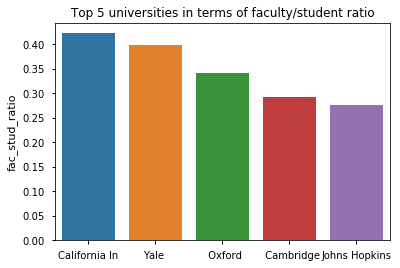

In [9]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_facStudRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_facStudRatio.head().fac_stud_ratio)
ax.set_title('Top 5 universities in terms of faculty/student ratio')

### 1.b - Best university in terms of ratio of international students <a class="anchor" id="1.b"></a>

We use strategy that is exactly the same than for the 1.a

In [10]:
df_topUni['international_ratio'] = df_topUni['international_student']/df_topUni['total_student']
sorted_by_internationalRatio = df_topUni.sort_values('international_ratio',ascending=False)
sorted_by_internationalRatio.head()

,school_name,total_staff,international_staff,total_student,international_student,country,region,fac_stud_ratio,international_ratio
rank,,,,,,,,,
35,London School of Economics and Political Scien...,1088.0,687.0,9760.0,6748.0,United Kingdom,Europe,0.111475,0.691393
12,Ecole Polytechnique Fédérale de Lausanne (EPFL),1695.0,1300.0,10343.0,5896.0,Switzerland,Europe,0.163879,0.570047
8,Imperial College London,3930.0,2071.0,16090.0,8746.0,United Kingdom,Europe,0.244251,0.543567
200,Maastricht University,1277.0,502.0,16385.0,8234.0,Netherlands,Europe,0.077937,0.502533
47,Carnegie Mellon University,1342.0,425.0,13356.0,6385.0,United States,North America,0.100479,0.478062


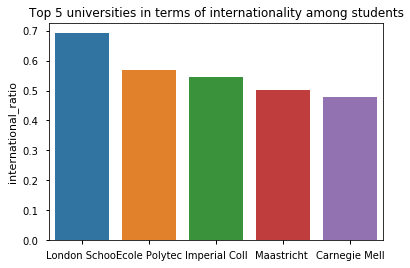

In [11]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_internationalRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_internationalRatio.head().international_ratio)
ax.set_title('Top 5 universities in terms of internationality among students')

This is the top 5 university in terms of international students/total students ratio. 

### 1.c - Aggregated by country <a class="anchor" id="1.c"></a>

Because it wasn't so clear how we should aggregate the data, we decided to consider the ```mean()``` as aggregation function which will give us the ranking of countries according to :
* ratio of faculty staff over students
* ratio of international students

In [12]:
best_countries_by_facStudRatio = df_topUni.groupby('country').mean().sort_values('fac_stud_ratio',ascending=False)
best_countries_by_facStudRatio[['fac_stud_ratio']].head()

,fac_stud_ratio
country,
Russia,0.221910
Denmark,0.186580
Saudi Arabia,0.175828
Singapore,0.162279
Japan,0.155840


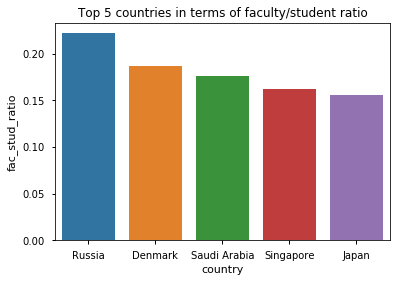

In [13]:
ax = sns.barplot(x=best_countries_by_facStudRatio.head().index, y=best_countries_by_facStudRatio.head().fac_stud_ratio)
ax.set_title('Top 5 countries in terms of faculty/student ratio')

In [14]:
best_countries_by_internationalRatio = df_topUni.groupby('country').mean().sort_values('international_ratio',ascending=False)
best_countries_by_internationalRatio[['international_ratio']].head()

,international_ratio
country,
United Kingdom,0.351308
Australia,0.346878
Switzerland,0.313816
Hong Kong,0.312148
Austria,0.306095


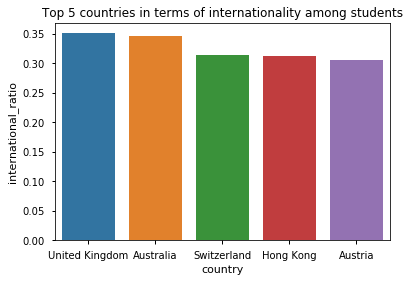

In [15]:
ax = sns.barplot(x=best_countries_by_internationalRatio.head().index, y=best_countries_by_internationalRatio.head().international_ratio)
ax.set_title('Top 5 countries in terms of internationality among students')

### 1.d - Aggregated by region <a class="anchor" id="1.d"></a>

Very similar strategy than the one used in 1.c

In [16]:
best_regions_by_facStudRatio = df_topUni.groupby('region').mean().sort_values('fac_stud_ratio',ascending=False)
best_regions_by_facStudRatio[['fac_stud_ratio']]

,fac_stud_ratio
region,
North America,0.144831
Asia,0.134673
Europe,0.120003
Latin America,0.096779
Africa,0.088450
Oceania,0.075003


In [17]:
best_regions_by_internationalRatio = df_topUni.groupby('region').mean().sort_values('international_ratio',ascending=False)
best_regions_by_internationalRatio[['international_ratio']]

,international_ratio
region,
Oceania,0.329077
Europe,0.245932
North America,0.202437
Africa,0.169703
Asia,0.132394
Latin America,0.071751


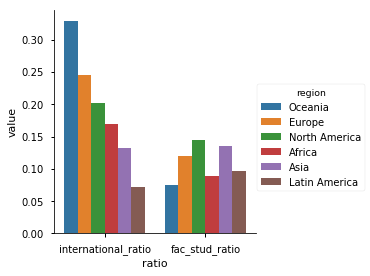

In [18]:
# format the dataframe to make a nice barplot
df = best_regions_by_internationalRatio[['international_ratio']].merge(best_regions_by_facStudRatio[['fac_stud_ratio']], left_index=True, right_index=True)
df.reset_index(inplace=True)
df = pd.melt(df, id_vars=['region'], var_name="ratio", value_name='value')
# plot the barplot with sns
ax = sns.factorplot(x='ratio', y='value', hue='region', data=df, kind='bar')

This is the 6 regions classified by international students ratio on the left and weighted with the faculty / students ratio on the right

## 2 - Times Higher Education <a class="anchor" id="2"></a>

Because we do not have direct access to some informations (e.g. International Students, Total Staff) we will infer them using the informations we have.

In [19]:
def find_region_from_country(country):
    """
        use restcountries.eu API to return the region name from the country name
        
        @params:
        - country : the country to find the region from
    """
    # with further investigation we realised that South Korea is not recognized well by the API 
    # so we decided to handle that specific case separetly :
    if country == 'South Korea':
        return 'Asia'
    
    r = requests.get('https://restcountries.eu/rest/v2/name/' + country)
    
    try:
        region = r.json()[0]['region']
        if region == 'Americas':
            region = r.json()[0]['subregion']
    except(KeyError) as e:
        print("Couldn't find region for '{}'".format(country))
        region = np.nan
    
    return region


In [20]:
def get_ranking_times(path_to_dump):
    """
        generate a dataframe with the top 200 university from timeshighereducation.com
        
        @params:
        - path_to_dump : path were the dump of the data should be (will use it if already present and save there otherwise)
    """
    if(os.path.isfile(path_to_dump)):
        return pd.read_pickle(path_to_dump)
    
    r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')

    top_200 = []
    for (i,uni_dict) in enumerate(r.json()['data']):
        if(i>=200):
            break
        title = uni_dict['name']
        # We delete the '=' sign in the case of tie to be consistent with the first one
        rank = uni_dict['rank'].replace('=','')
        country = uni_dict['location']

        # We delete the thousands separator
        student_total = int(uni_dict['stats_number_students'].replace(',',''))
        pc_inter_student = float(uni_dict["stats_pc_intl_students"].replace('%',''))/100
        student_to_staff_ratio = float(uni_dict["stats_student_staff_ratio"])

        # infer some informations using the percentage and ratio
        student_inter = student_total*pc_inter_student
        staff_total = student_total/student_to_staff_ratio

        top_200.append({'school_name': title, 
                            'rank': rank, 
                            'country': country,
                            'international_student' : int(round(student_inter)),
                            'total_staff' : int(round(staff_total)),
                            'total_student': student_total,
                            'region': find_region_from_country(country)
                           })
        
        # update the progress bar
        progress(i+1,200,'Analysing the JSON file')
        
    df = pd.DataFrame.from_dict(top_200)
    
    # We set Rank as an index
    df.set_index('rank',inplace=True)
    
    # Reorder the df columns for better output
    df = df[['school_name', 'total_staff', 'total_student', 'international_student', 'country', 'region']]

    df.to_pickle(path_to_dump)
    return df

In [21]:
df_times = get_ranking_times('times_backup')
df_times.head()

,school_name,total_staff,total_student,international_student,country,region
rank,,,,,,
1,University of Oxford,1822,20409,7755,United Kingdom,Europe
2,University of Cambridge,1687,18389,6436,United Kingdom,Europe
3,California Institute of Technology,340,2209,596,United States,Northern America
3,Stanford University,2113,15845,3486,United States,Northern America
5,Massachusetts Institute of Technology,1285,11177,3800,United States,Northern America


We now repeat the same steps as for the first exercise to analyse the different ratio such as faculty/student ratio and international/total students.

### 2.a - Best university in terms of ratio faculty members over students <a class="anchor" id="2.a"></a>

In [22]:
df_times['fac_stud_ratio'] = df_times['total_staff']/df_times['total_student']
sorted_by_facStudRatio = df_times.sort_values('fac_stud_ratio',ascending=False)
sorted_by_facStudRatio.head()

,school_name,total_staff,total_student,international_student,country,region,fac_stud_ratio
rank,,,,,,,
105,Vanderbilt University,3640,12011,1561,United States,Northern America,0.303056
109,University of Copenhagen,7413,30395,4255,Denmark,Europe,0.243889
12,Yale University,2827,12155,2553,United States,Northern America,0.232579
153,University of Rochester,2241,9636,2794,United States,Northern America,0.232565
13,Johns Hopkins University,3604,15498,3720,United States,Northern America,0.232546


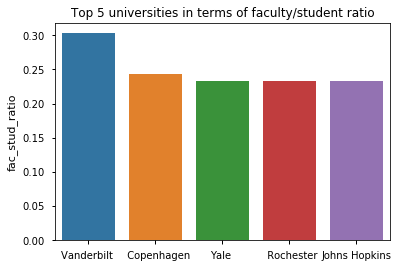

In [23]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_facStudRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_facStudRatio.head().fac_stud_ratio)
ax.set_title('Top 5 universities in terms of faculty/student ratio')

We can observe that in this ranking that good fac/stud ratio are not ranked as well as in the first ranking. The best faculty/student ratio is only ranked 105 when it was 4 in the other ranking. We also observe that the value differ from the previous ranking and that we see only 2 universities in common in the top 5 (Yale and Johns Hopkins).

### 2.b - Best university in terms of ratio of international students <a class="anchor" id="2.b"></a>

In [24]:
df_times['international_ratio'] = df_times['international_student']/df_times['total_student']
sorted_by_internationalRatio = df_times.sort_values('international_ratio',ascending=False)
sorted_by_internationalRatio.head()

,school_name,total_staff,total_student,international_student,country,region,fac_stud_ratio,international_ratio
rank,,,,,,,,
25,London School of Economics and Political Science,825,10065,7146,United Kingdom,Europe,0.081967,0.709985
179,University of Luxembourg,340,4969,2832,Luxembourg,Europe,0.068424,0.569934
8,Imperial College London,1391,15857,8721,United Kingdom,Europe,0.087722,0.549978
38,École Polytechnique Fédérale de Lausanne,886,9928,5460,Switzerland,Europe,0.089243,0.549960
103,Maastricht University,929,16727,8364,Netherlands,Europe,0.055539,0.500030


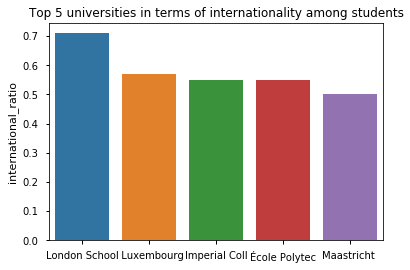

In [25]:
# format the name to fit in the bar plot
shorten_school_name = [x.replace('of', '').replace('University', '')[0:13] for x in sorted_by_internationalRatio.head().school_name]
ax = sns.barplot(x=shorten_school_name, y=sorted_by_internationalRatio.head().international_ratio)
ax.set_title('Top 5 universities in terms of internationality among students')

For the international ratio we observe this time comparable result than the one we had with the previous ranking. Only luxembourg university appeared in the top 5 and wasn't here before.

### 2.c - Aggregated by country <a class="anchor" id="2.c"></a>

In [26]:
best_countries_by_facStudRatio = df_times.groupby('country').mean().sort_values('fac_stud_ratio',ascending=False)
best_countries_by_facStudRatio[['fac_stud_ratio']].head()

,fac_stud_ratio
country,
Denmark,0.160176
Italy,0.138870
Russian Federation,0.136989
Japan,0.132105
United States,0.106393


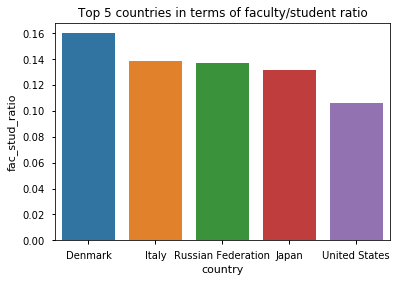

In [27]:
ax = sns.barplot(x=best_countries_by_facStudRatio.head().index, y=best_countries_by_facStudRatio.head().fac_stud_ratio)
ax.set_title('Top 5 countries in terms of faculty/student ratio')

Yet again for the faculty/student ratio by country, we observe comparable result as before only with Singapour and Saudi Arabia out replaced by Italy and United states.

In [28]:
best_countries_by_internationalRatio = df_times.groupby('country').mean().sort_values('international_ratio',ascending=False)
best_countries_by_internationalRatio[['international_ratio']].head()

,international_ratio
country,
Luxembourg,0.569934
United Kingdom,0.365478
Hong Kong,0.327989
Switzerland,0.314280
Australia,0.307502


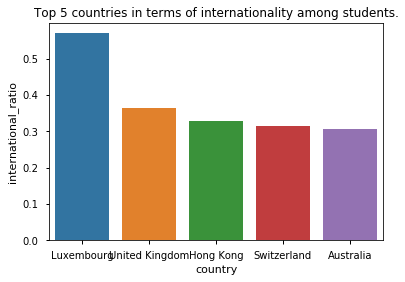

In [29]:
ax = sns.barplot(x=best_countries_by_internationalRatio.head().index, y=best_countries_by_internationalRatio.head().international_ratio)
ax.set_title('Top 5 countries in terms of internationality among students.')

We can observe only little change here with luxembourg instead of Austria.

### 2.d - Aggregated by region <a class="anchor" id="2.d"></a>

In [30]:
best_regions_by_facStudRatio = df_times.groupby('region').mean().sort_values('fac_stud_ratio',ascending=False)
best_regions_by_facStudRatio[['fac_stud_ratio']]

,fac_stud_ratio
region,
Northern America,0.101658
Africa,0.085487
Asia,0.080347
Europe,0.065951
Oceania,0.039893


In [31]:
best_regions_by_internationalRatio = df_times.groupby('region').mean().sort_values('international_ratio',ascending=False)
best_regions_by_internationalRatio[['international_ratio']]

,international_ratio
region,
Oceania,0.305558
Europe,0.244658
Northern America,0.185585
Africa,0.180024
Asia,0.165242


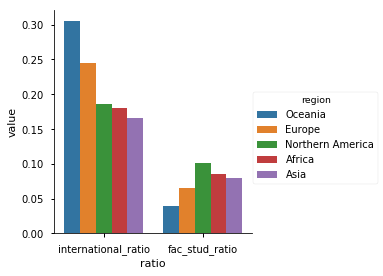

In [32]:
# format the dataframe to make a nice barplot
df = best_regions_by_internationalRatio[['international_ratio']].merge(best_regions_by_facStudRatio[['fac_stud_ratio']], left_index=True, right_index=True)
df.reset_index(inplace=True)
df = pd.melt(df, id_vars=['region'], var_name="ratio", value_name='value')
# plot the barplot with sns
ax = sns.factorplot(x='ratio', y='value', hue='region', data=df, kind='bar')

At the end we observe very comparable results on the international ratio by region but the faculty/student ratio by range seems to have drastically changed. We can also note that this ranking doesn't contain any universty in South America among the top 200.

## 3 - Merging the two data frames <a class="anchor" id="3"></a>
### 3.1 - Matching the school names <a class="anchor" id="3.1"></a>

Because we do not have the same information than in the first table we try to get the informations using the first table. But first we need to see how the school names can differ between the two tables (e.g. "Massachusetts Institute of Technology (MIT)" is different from "Massachusetts Institute of Technology"). 

We will proceed in two steps: 
1. We will first clean the school names in both dataframes by :
    * Converting to Lowercase
    * Deleting accents
    * Deleting ponctuation {,.-}
    * Deleting the initials or the school put in parenthesis (e.g. (EPFL) or (MIT))
    * Deleting the trailing "the"
2. We will try to identify similar names by :
    * Considering if they belong to the same country
    * Seeing if one is contained in the other
    * Looking at the [Levenstein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) (It computes the "minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other") between the words that are different between the two rankings. This distance is considered relative to the maximum length of both names to have a relative number for all school names. 
3. We will identify the remaining unmatched names manually : 
    * We group them by similar countries because it doesn't make sense to consider possibilities of schools from different countries to be similar.

#### 3.1.1 - Cleaning the names <a class="anchor" id="3.1.1"></a>

In [33]:
def how_different(df_times,df_topUni):
    """ 
    Will return the intersection set of school names from the two dataframes. 
    This helps us count the number of unmatched school names between the two df.
    
    @params:
    - df_times, df_topUni : the two dataframes for which we wish to compare the 'School Name' values
    
    """
    names_times = set(sorted(list(df_times['school_name'].values)))
    names_topUni = set(sorted(list(df_topUni['school_name'].values)))
    difference = names_times.symmetric_difference(names_topUni)
    return difference

def clean_data(x):
    """
    Performs very basic string cleaning on a serie of School names.
    It puts all names in lower case, gets rid of the accents,
    deletes the symbols that are added between parenthesis (like EPFL),
    the trailing "the" and some ponctuation.
    
    @params:
    - x: the data frame to clean
    """
    # get small latters
    x = x.lower()
    
    # delete accents
    x = unidecode(x)
    
    # delete parenthesis, points, comas, dash and trailing "the"
    x = re.sub("[.,]","",x)
    x = re.sub(r"(\s)\-(\s)", r"\1\2",x) #dash between two spaces replace by nothing
    x = re.sub(r"([a-z])\-([a-z])", r"\1 \2",x) #dash between two words replace by space
    x = re.sub("[\(].*?[\)]", "", x)
    x = re.sub("^(the)\s", "",x)
    
    # delete any space before or after string
    return x.strip()


In [34]:
print("Before data cleaning, we have {} different school names.".format(len(how_different(df_times,df_topUni))))
df_times['school_name'] = df_times['school_name'].apply(clean_data)
df_topUni['school_name'] = df_topUni['school_name'].apply(clean_data)
print("After data cleaning, we have {} different school names.".format(len(how_different(df_times,df_topUni))))

Before data cleaning, we have 190 different school names.
After data cleaning, we have 116 different school names.


#### 3.1.2 - Automatic Matching <a class="anchor" id="3.1.2"></a>

We already matched 74 school just with a very quick cleaning of the data now let's try to identify similar names.

In [35]:
def get_difference(s1,s2):
    """ 
    Many name of school contain same words "technology","university", 
    we want to get rid of them such that the relative difference 
    really characterises words that are different. 
    Therefore we return only the words for s1 and s2 that are not in both strings.
    
    @params:
    - s1,s2 : the two strings that we wish to compare
    
    """
    d1 = [w for w in s1.split() if w not in s2]
    d2 = [w for w in s2.split() if w not in s1]
    return " ".join(d1)," ".join(d2)

Now we want to make a function that help us checking in what extend two school have similar names. This function will need to check the country as it is an important factor to check if it is actually the same university. Let's briefly check in a first part if we have the same country name in the s2 different df.

In [36]:
print('Country in topUni but not in times:')
print([x for x in df_topUni.country.unique() if x not in df_times.country.unique()])
print('Country in times but not in topUni:')
print([x for x in df_times.country.unique() if x not in df_topUni.country.unique()])

Country in topUni but not in times:
['Argentina', 'Russia', 'Malaysia', 'Brazil', 'Mexico', 'Chile', 'Israel', 'India', 'Saudi Arabia']
Country in times but not in topUni:
['Luxembourg', 'Russian Federation']


We observe that topUni has many more countries in the top 200 than times but more importantly we see that there is a difference between Russia name in the 2 df. We decide to change Russian Federation from times to match with the name in the topUni df.

In [37]:
# set russian federation to russia
df_times.loc[df_times['country'] == 'Russian Federation', 'country'] = 'Russia'

In [38]:
def check_similarity(s1,s2,threshold,combined):
    """
    This utility function helps us checking in what magnitude are two school names identical.
    It uses 3 checks :
    - are the two school names from the same country
    - is one of the name included in the second
    - what is the Levenshtein distance relative to the max length of the two
    
    @params:
    - s1,s2 : the two school names
    - threshold : the limit for the relative Levenshtein distance s.t. the names are considered similar
    - combined : a dataframe containing all 'School Name' and 'Country'
    """
    
    o,n = get_difference(s1,s2)
    same_country = (combined.loc[s1,'country'] == combined.loc[s2,'country'])
    
    if(len(o) == 0 or len(n)==0):
        # One school name was contained in the other
        return same_country,same_country,0
    else:
        max_length =  len(n) if (len(n) > len(o)) else len(o)
        relative_diff = float(editdistance.eval(o,n))/max_length

        # Then we compute some of our conditions that determine if the strings are similar or not.
        similar_ortho = (relative_diff < threshold)
        considered_similar = (similar_ortho and same_country)
        
        return considered_similar,same_country,relative_diff

def get_potentially_similar(df_times,df_topUni,threshold):
    """
    Utility function returning a mapping of the School names 
    in df_times to School names in df_topUni that are considered similar
    
    @params:
    - df_times,df_topUni: the two dataframes between which we wish to match the School Names
    """
    reduced_times = df_times.reset_index()[['country', 'school_name']]
    reduced_topUni = df_topUni.reset_index()[['country', 'school_name']]
    
    # We want a dataframe giving us the country for each school
    combined = reduced_times.merge(reduced_topUni,how='outer').set_index('school_name')
    
    names_times = set(sorted(list(df_times['school_name'].values)))
    names_topUni = set(sorted(list(df_topUni['school_name'].values)))
    
    unmatched_times = list(names_times-names_topUni)
    unmatched_topUni = list(names_topUni - names_times)
    
    scores = []
    matching = {}
    for name_1 in unmatched_times:
        for name_2 in unmatched_topUni:
            if(name_1 != name_2):
                # we check different conditions
                considered_similar,same_country,relative_diff = check_similarity(name_1,name_2,threshold,combined)
                if(same_country):
                    # We store the score between school names that are part 
                    # of the same country to be able to explore it by hand later on
                    if name_1 not in matching.keys() and name_2 not in matching.values():
                        scores.append({"name_times":name_1,"name_topUni":name_2,"score":relative_diff})
                
                if(considered_similar):
                    # They are similar, we will set name_1 to be replaced by name_2
                    matching[name_1] = name_2
    
    scores_df = pd.DataFrame.from_dict(scores)
    return matching,scores_df

def make_homogeneous(x,to_homogeneous):
    """
    Returns either the value in to_homogeneous corresponding 
    to x or x itself if it isn't part of the dictionnary.
    
    @params:
    - x : a school name
    - to_homogeneous : the dictionnary of mappings between 
    school names (see get_potentially_similar)
    """
    if(x in to_homogeneous.keys()): return to_homogeneous[x]
    else: return x

def match_school_names(df_times,df_topUni,threshold):
    """
    Will modify the school names of df_times to match them when 
    possible with the school names of df_topUni.
    
    @params:
    - df_times, df_topUni: the dataframes of the two rankings 
    for which we wish to match the school names.
    """
    matching, scores_df = get_potentially_similar(df_times,df_topUni,threshold)

    df_times['school_name'] = df_times['school_name'].apply(make_homogeneous,to_homogeneous = matching)
    return matching,scores_df

In [39]:
print("Before matching names automatically, we have {} different school names.".format(len(how_different(df_times,df_topUni))))
automatic_matching, scores_df = match_school_names(df_times, df_topUni, 0.35)
print("After matching names automatically, we have {} different school names.".format(len(how_different(df_times,df_topUni))))

Before matching names automatically, we have 116 different school names.
After matching names automatically, we have 96 different school names.


The different function described above allowed us to automatically match 20 more schools together. For the rest it also provides us with a similarity score that will help us manually match the last remaining school.

A score below 0.35 in our similarity index was leading directly to a matching as we set the treshold value to 0.35 in the function call just above. We set this treshold value using the df output below. As we can see the matching are correct up to this point.

In [40]:
scores_df = scores_df.sort_values('score',ascending=True)
scores_df[scores_df['score']<0.35]

,name_times,name_topUni,score
0,wageningen university & research,wageningen university,0.000000
153,trinity college dublin,trinity college dublin the university of dublin,0.000000
63,scuola superiore sant'anna,scuola superiore sant'anna pisa di studi unive...,0.000000
96,university of north carolina at chapel hill,university of north carolina chapel hill,0.000000
135,karlsruhe institute of technology,kit karlsruhe institute of technology,0.000000
13,eth zurich swiss federal institute of technol...,eth zurich swiss federal institute of technology,0.000000
137,university of montreal,universite de montreal,0.230769
148,free university of berlin,freie universitaet berlin,0.277778
112,humboldt university of berlin,humboldt universitat zu berlin,0.285714
76,technical university of berlin,technische universitat berlin,0.304348


#### 3.1.3 - Manual Matching <a class="anchor" id="3.1.3"></a>

For the remaining university we decided to match them manually if possible using the score provided by our function

In [41]:
def print_manual_matching(manual_matching):
    """
    Utility function to print the manual matching for later reference by reviewer.
    
    @params:
    - manual_matching: a dict of matching from the times to topUni ranking for school names.
    """
    print("\nWe have matched manually:")
    for n1 in manual_matching.keys():
        print("   {} --> {}".format(n1,manual_matching[n1]))
    print("")

In [42]:
def match_manually(path_to_dump,scores_df,automatic_matching):
    """
    Function to match manually the remaining names. 
    It will either use the dump or will ask the user to choose what names are the same. 
    It will only propose matching of similar countries and that haven't yet been matched 
    between the two rankings.
    
    @params:
    - path_to_dump: relative path where the backup is located or where it should be saved 
    if it hasn't yet been created
    - scores_df: the dataframe containing the pairs of names from the two rankings as well 
    as the pair scores only for pairs of the same country (as produced by match_school_names)
    - automatic_matching: dict matching times with topUni that has already been produced by automatic method
    """
    if(os.path.isfile(path_to_dump)):
        manual_matching = pickle.load(open(path_to_dump,"rb"))
    
    else:
        # this cell helped us perform efficiently the manual matching of the remaining universities:
        for i, name_times in enumerate(scores_df[scores_df['score']>=0.35].name_times.unique()):
            progress(i, len(scores_df[scores_df['score']>=0.35].name_times.unique()), 'Matching School Name')
            print()
            if name_times not in automatic_matching.keys():
                print('does "{}" match with ? \n'.format(name_times))
                current_name_df = scores_df[scores_df['score']>=0.35].query('name_times == @name_times').reset_index()
                possible_choice = 0
                for index, row in current_name_df.iterrows():
                    if row.name_topUni not in automatic_matching.values():
                        print('{}. {} (score: {})'.format(index+1, row.name_topUni, round(row.score, 3)))
                        possible_choice += 1
                print('0. none of the above')
                time.sleep(0.2)
                r = 0
                if possible_choice > 0:
                    r = int(input())
                if r > 0:
                    matched_country =  current_name_df.loc[r-1].name_topUni
                    automatic_matching[name_times] = matched_country
                    manual_matching[name_times] = matched_country
                    tmp = "{} --> {}\n".format(name_times,current_name_df.loc[r-1].name_topUni)
                    result += tmp
            clear_output()

        progress(100, 100, 'Done matching manually')
        pickle.dump(manual_matching,open(path_to_dump,"wb"))
        
    df_times['school_name'] = df_times['school_name'].apply(make_homogeneous,to_homogeneous = manual_matching)
    print_manual_matching(manual_matching)
    return automatic_matching

In [43]:
# after manual matching we can now perform the matching on the df and check how we improved
print("Before manually matching names, we have {} different school names.".format(len(how_different(df_times,df_topUni))))
complete_matching = match_manually('matching_backup',scores_df,automatic_matching)
print("After manually matching names, we have {} different school names.".format(len(how_different(df_times,df_topUni))))

Before manually matching names, we have 96 different school names.

We have matched manually:
   pierre and marie curie university --> universite pierre et marie curie
   heidelberg university --> ruprecht karls universitat heidelberg
   autonomous university of barcelona --> universidad autonoma de madrid
   university of freiburg --> albert ludwigs universitaet freiburg
   university of tubingen --> eberhard karls universitat tubingen
   korea advanced institute of science and technology --> kaist  korea advanced institute of science & technology
   university college london --> ucl
   lmu munich --> ludwig maximilians universitat munchen

After manually matching names, we have 80 different school names.


This step allowed us to match 16 more universities.

### 3.2 - Merging <a class="anchor" id="3.2"></a>

Now that we have only so few different names we can consider that the rest are really different from the two rankings. Indeed we have performed all the matching that we could. We merge the two dataframes based on 'School Name' (using a inner join to discard the names that are not in both tables), we add suffixes to columns of both frames to be able to combine them later on.

In [44]:
df_times_to_merge = df_times.reset_index()
df_topUni_to_merge = df_topUni.reset_index()
merged_df = df_topUni_to_merge.merge(df_times_to_merge,on='school_name',how='inner', suffixes=('_topUni', '_times'))
merged_df.head()

,rank_topUni,school_name,total_staff_topUni,international_staff,total_student_topUni,international_student_topUni,country_topUni,region_topUni,fac_stud_ratio_topUni,international_ratio_topUni,rank_times,total_staff_times,total_student_times,international_student_times,country_times,region_times,fac_stud_ratio_times,international_ratio_times
0,1,massachusetts institute of technology,2982.0,1679.0,11067.0,3717.0,United States,North America,0.269450,0.335863,5,1285,11177,3800,United States,Northern America,0.114968,0.339984
1,2,stanford university,4285.0,2042.0,15878.0,3611.0,United States,North America,0.269870,0.227422,3,2113,15845,3486,United States,Northern America,0.133354,0.220006
2,3,harvard university,4350.0,1311.0,22429.0,5266.0,United States,North America,0.193945,0.234785,6,2284,20326,5285,United States,Northern America,0.112368,0.260012
3,4,california institute of technology,953.0,350.0,2255.0,647.0,United States,North America,0.422616,0.286918,3,340,2209,596,United States,Northern America,0.153916,0.269805
4,5,university of cambridge,5490.0,2278.0,18770.0,6699.0,United Kingdom,Europe,0.292488,0.356899,2,1687,18389,6436,United Kingdom,Europe,0.091740,0.349992


Now because we don't know what ranking to believe in terms of :
* International Students
* Total Students
* Total Staff

We decided to take the mean of the values given by both in the combined dataframe. If we were to trust more one ranking than the other we could use a weighted average.

In [45]:
def avg_col(x,name_col_1,name_col_2):
    """
    Will return the average of two columns of a dataframe ignoring NaN values.
    
    @params:
    - x : dataframe in which the columns are.
    - name_col_1,name_col_2 : the name of the two columns we wish to aggregate.
    """
    if pd.isnull(x[name_col_1]) and pd.isnull(x[name_col_2]):
        print("Houston we have a problem !")
    if pd.isnull(x[name_col_1]):
        return x[name_col_2]
    elif pd.isnull(x[name_col_2]):
        return x[name_col_1]
    else: return (x[name_col_1]+x[name_col_2])/2

In [46]:
# compute average for the different column
merged_df['total_staff'] = merged_df.apply(avg_col,name_col_1 ='total_staff_topUni',name_col_2='total_staff_times',axis=1)
merged_df['total_student'] = merged_df.apply(avg_col,name_col_1 ='total_student_topUni',name_col_2='total_student_times',axis=1)
merged_df['international_student'] = merged_df.apply(avg_col,name_col_1 ='international_student_topUni',name_col_2='international_student_times',axis=1)

# order, select, and rename relevant columns
merged_df = merged_df[['rank_topUni','rank_times','total_staff','international_staff','total_student','international_student','country_times','region_topUni','school_name']]
merged_df = merged_df.set_index('school_name')
merged_df.rename(columns={'country_times':'country', 'region_topUni':'region'}, inplace=True)

merged_df.head()

,rank_topUni,rank_times,total_staff,international_staff,total_student,international_student,country,region
school_name,,,,,,,,
massachusetts institute of technology,1,5,2133.5,1679.0,11122.0,3758.5,United States,North America
stanford university,2,3,3199.0,2042.0,15861.5,3548.5,United States,North America
harvard university,3,6,3317.0,1311.0,21377.5,5275.5,United States,North America
california institute of technology,4,3,646.5,350.0,2232.0,621.5,United States,North America
university of cambridge,5,2,3588.5,2278.0,18579.5,6567.5,United Kingdom,Europe


### 4 - Exploratory analysis <a class="anchor" id="4"></a>


To perform a relevant exploratory analysis, we start by watching our data frame to see if some correlation between any pair of variables could be evaluated to create a smart analysis. 

In [47]:
merged_df.head()

,rank_topUni,rank_times,total_staff,international_staff,total_student,international_student,country,region
school_name,,,,,,,,
massachusetts institute of technology,1,5,2133.5,1679.0,11122.0,3758.5,United States,North America
stanford university,2,3,3199.0,2042.0,15861.5,3548.5,United States,North America
harvard university,3,6,3317.0,1311.0,21377.5,5275.5,United States,North America
california institute of technology,4,3,646.5,350.0,2232.0,621.5,United States,North America
university of cambridge,5,2,3588.5,2278.0,18579.5,6567.5,United Kingdom,Europe


We choose to perform these exploratory analysis : 
* [4.1 - Does university size influence internationality rate ?](#4.1)
* [4.2 - Does university size influence ranking ?](#4.2)
* [4.3 - Are european universities more international than other regions ?](#4.3)
* [4.4 - Do english speaking countries get more international students than others ?](#4.4)
* [4.5 - Do international students influence ranking ?](#4.5)

### 4.1 - Does university size influence internationality rate ? <a class="anchor" id="4.1"></a>

We have seen in the merged dateframe that the size between universities is very different. International students and staffs may be attracted by big universities. We want to perform a data analysis for this assumption. 

We first calculate our indicator of internationality rate for each universities. We calculate the ratio for the total (student + staff), and for both separately.

In [48]:
inter_dimension = merged_df
inter_dimension['ratio_total'] = round(100*(inter_dimension['international_student']+inter_dimension['international_staff'])/(inter_dimension['total_student']+inter_dimension['total_staff']),2)
inter_dimension['ratio_student'] = round(100*(inter_dimension['international_student'])/(inter_dimension['total_student']),2)
inter_dimension['ratio_staff'] = round(100*(inter_dimension['international_staff'])/(inter_dimension['total_staff']),2)

For the total percentage (including staff and students), we drop the rows where ratio_total is NaN and sort the table by ratio_total. 

In [49]:
inter_total = inter_dimension[np.isfinite(inter_dimension['ratio_total'])].sort_values('ratio_total',ascending=False)
inter_total[['ratio_total', 'total_staff', 'total_student']].head()

,ratio_total,total_staff,total_student
school_name,,,
london school of economics and political science,70.24,956.5,9912.5
ecole polytechnique federale de lausanne,61.07,1290.5,10135.5
imperial college london,57.98,2660.5,15973.5
maastricht university,49.84,1103.0,16556.0
ucl,49.30,4615.5,30692.0


We create intervals to cluster the data in different discret groups.

In [50]:
inter_dimension['total_staff'].describe()
cut_staff = np.linspace(80, 8000, num=10)

inter_dimension['total_student'].describe()
cut_student = np.linspace(80, 80000, num=10)

inter_dimension['staff'] = pd.cut(inter_dimension['total_staff'], cut_staff)
inter_dimension['students'] = pd.cut(inter_dimension['total_student'], cut_student)

We create a heatmap table in order to see the proportion of international students compared to the number of staff and students in the school.

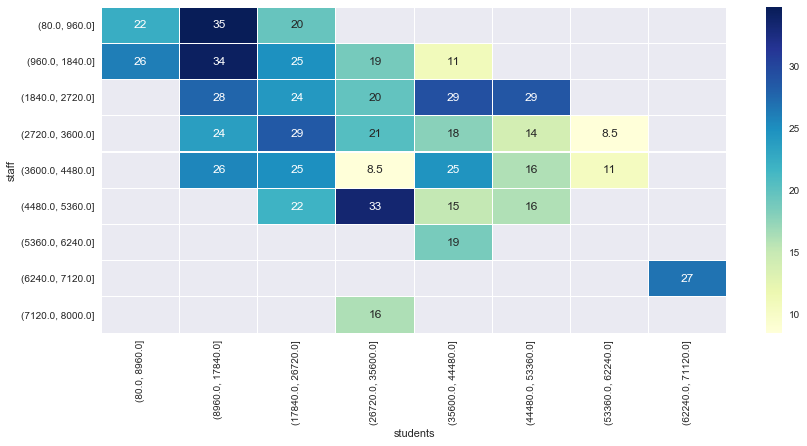

In [51]:
heat_map = inter_dimension.pivot_table(index='staff', columns='students', values='ratio_total', aggfunc=np.mean)
sns.set()
f, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(heat_map, annot=True, linewidths=0.1, ax=ax, cmap="YlGnBu")

We cannot draw real conclusions from this heatmap. The international percentage seem to be higher when the school size is small. There are exceptions in the biggest university.

In order to have a better understanding, we decide to see the impacts of school size, separately in term of student and staff separately, on internationality ratio.

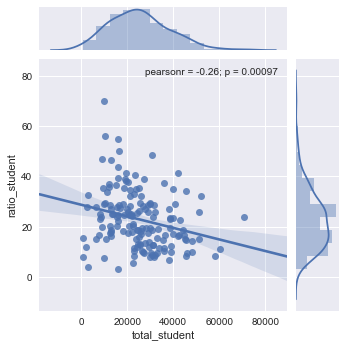

In [52]:
sns.set(style="darkgrid", color_codes=True)
sns.jointplot("total_student", "ratio_student", data=inter_total, kind="reg", size=5)

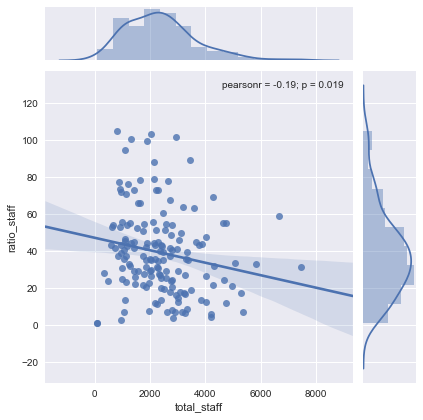

In [53]:
sns.set(style="darkgrid", color_codes=True)
sns.jointplot("total_staff", "ratio_staff", data=inter_total, kind="reg", size=6)

On each figure we have displayed a regression line. These analysis show us that small universities are on average more international than big ones.

### 4.2 - Does university size influence ranking ? <a class="anchor" id="4.2"></a>

We want to understand now if the university size influence our ranking. In term of university size, we will include students and staff together. 

We first convert our ranking columns into int format and create the column for total university size.

In [54]:
merged_df['rank_topUni'] = merged_df['rank_topUni'].astype(int)
merged_df['rank_times'] = merged_df['rank_times'].astype(int)
merged_df['total'] = merged_df['total_student'] + merged_df['total_staff']

In [55]:
merged_df['total'].describe()
cut_total = np.linspace(80, 80000, num=10)
merged_df['total_cut'] = pd.cut(merged_df['total'], cut_total)

In [56]:
df = merged_df.pivot_table(index='total_cut', values=['rank_topUni','rank_times'], aggfunc=np.mean)
df

,rank_times,rank_topUni
total_cut,,
"(80.0, 8960.0]",127.100000,121.600000
"(8960.0, 17840.0]",93.166667,90.966667
"(17840.0, 26720.0]",76.925000,80.500000
"(26720.0, 35600.0]",96.523810,92.761905
"(35600.0, 44480.0]",72.833333,79.111111
"(44480.0, 53360.0]",66.428571,81.642857
"(53360.0, 62240.0]",74.500000,91.750000
"(62240.0, 71120.0]",56.000000,163.000000
"(71120.0, 80000.0]",22.000000,31.000000


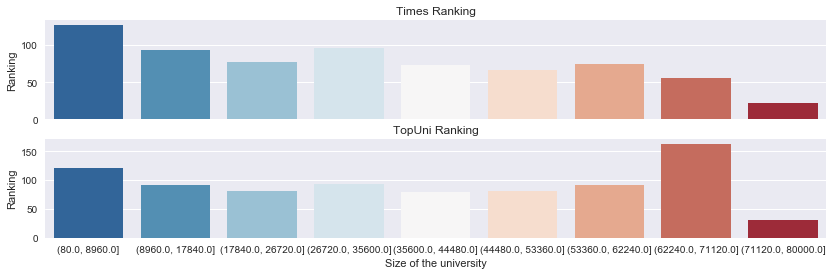

In [57]:
df.index = df.index.values.astype(str)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 4), sharex=True)

sns.barplot(df.index, df.rank_times.values, palette="RdBu_r", ax=ax1)
ax1.set_ylabel("Ranking")
ax1.set_title('Times Ranking')

sns.barplot(df.index, df.rank_topUni.values, palette="RdBu_r", ax=ax2)
ax2.set_ylabel("Ranking")
ax2.set_xlabel("Size of the university")
ax2.set_title("TopUni Ranking")

It is hard to conclude wether the size influences the ranking. Nevertheless for Times ranking it seems like the bigger the school the better it is ranked. While for Top Uni the correlation is less clear.

### 4.3 - Are european universities more international than other regions ?<a class="anchor" id="4.3"></a>

The european region is made of a lot of diverse countries with different universities. These universities are close to each other. We assume that for that localization reason, european may get more international people than other. We will perform an analysis to respond to our assumption.

In [58]:
merged_df[['region', 'ratio_total']].head()

,region,ratio_total
school_name,,
massachusetts institute of technology,North America,41.02
stanford university,North America,29.33
harvard university,North America,26.67
california institute of technology,North America,33.75
university of cambridge,Europe,39.90


In [59]:
df = merged_df.pivot_table(index='region', values='ratio_total', aggfunc=np.mean).sort_values('ratio_total')
df

,ratio_total
region,
Africa,17.830000
Asia,18.887143
North America,20.914231
Europe,27.153158
Oceania,34.363333


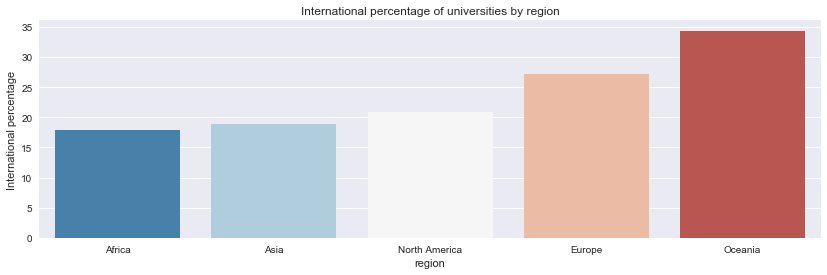

In [60]:
f, (ax1) = plt.subplots(1, 1, figsize=(14, 4), sharex=True)

sns.barplot(df.index, df.ratio_total.values, palette="RdBu_r", ax=ax1)
ax1.set_ylabel("International percentage")
ax1.set_title('International percentage of universities by region')

We see that both Europe and Oceania have a bigger percentage of international students than other regions. We will check in more details Oceania to understand why they have such a big value. Maybe they have only few universities in this ranking and the analysis could be non relevant. 

In [61]:
oceania_df = merged_df[['region','ratio_total']].loc[merged_df['region'] == 'Oceania']
oceania_df.sort_values('ratio_total')

,region,ratio_total
school_name,,
university of western australia,Oceania,27.50
university of auckland,Oceania,29.32
university of queensland,Oceania,30.10
university of adelaide,Oceania,33.24
monash university,Oceania,34.03
university of sydney,Oceania,36.15
university of new south wales,Oceania,36.95
australian national university,Oceania,39.57
university of melbourne,Oceania,42.41


We see that they have 9 universities included in the average so that is considered as relevant. We conclude that Europe and Oceania have both a big international percentage of people in their universities compared to other regions.

### 4.4 - Do english speaking countries get more international students than others ?<a class="anchor" id="4.4"></a>

We want to see if english speaking countries get more international students than other. We assume that it could be the case but it is hard to know without seeing the data analysis. 

We see all our the country concerned by the analysis.

In [62]:
merged_df.country.unique()

array(['United States', 'United Kingdom', 'Switzerland', 'Singapore',
       'Australia', 'China', 'Hong Kong', 'Japan', 'Canada', 'South Korea',
       'Netherlands', 'France', 'Germany', 'Belgium', 'Denmark', 'Taiwan',
       'Sweden', 'New Zealand', 'Ireland', 'Russia', 'Finland', 'Norway',
       'Austria', 'Spain', 'South Africa', 'Italy'], dtype=object)

It's now easy to identify the english speaking countries : 'United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'South Africa'. We need to indicate this with a new column in the dataframe.

In [63]:
english_speaking_countries = ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'South Africa']
merged_df['english_speaking'] = 0
for index, row in merged_df.iterrows():
    if any(row['country'] in s for s in english_speaking_countries):
        merged_df.english_speaking.loc[index] = 1

We get this dataframe with all the informations that we need. We will now compare the english speaking universities with non english speaking universities.

In [64]:
merged_df[['country', 'english_speaking', 'ratio_student']].tail()

,country,english_speaking,ratio_student
school_name,,,
scuola normale superiore di pisa,Italy,0,8.02
scuola superiore sant'anna pisa di studi universitari e di perfezionamento,Italy,0,15.69
stockholm university,Sweden,0,8.61
texas a&m university,United States,1,8.55
maastricht university,Netherlands,0,50.13


In [65]:
df = merged_df.pivot_table(index='english_speaking', values='ratio_student', aggfunc=np.mean)
df

,ratio_student
english_speaking,
0,19.097887
1,25.991910


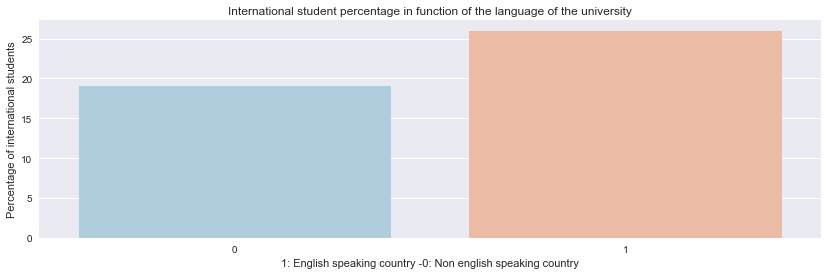

In [66]:
f, (ax1) = plt.subplots(1, 1, figsize=(14, 4), sharex=True)

sns.barplot(df.index, df.ratio_student.values, palette="RdBu_r", ax=ax1)
ax1.set_xlabel("1: English speaking country -0: Non english speaking country")
ax1.set_ylabel("Percentage of international students")
ax1.set_title('International student percentage in function of the language of the university')

We see that english speaking countries have on average 25% of international students while non speaking countries have 19%. We can therefore confirm our hypothesis that english speaking countries attract international students. 

### 4.5 - Do international students influence ranking ?<a class="anchor" id="4.5"></a>

We wonder if international students ratio influences both rankings. 

In [67]:
cut_ratio = np.linspace(0, 100, num=10)
merged_df['ratio_student_cut'] = pd.cut(merged_df['ratio_student'], cut_ratio)

In [68]:
df = merged_df.pivot_table(index='ratio_student_cut', values=['rank_topUni','rank_times'], aggfunc=np.mean)
df

,rank_times,rank_topUni
ratio_student_cut,,
"(0.0, 11.111]",111.625000,107.333333
"(11.111, 22.222]",84.535714,103.000000
"(22.222, 33.333]",86.269231,81.076923
"(33.333, 44.444]",74.190476,58.476190
"(44.444, 55.556]",58.800000,70.800000
"(55.556, 66.667]",38.000000,12.000000
"(66.667, 77.778]",25.000000,35.000000
"(77.778, 88.889]",NaN,NaN
"(88.889, 100.0]",NaN,NaN


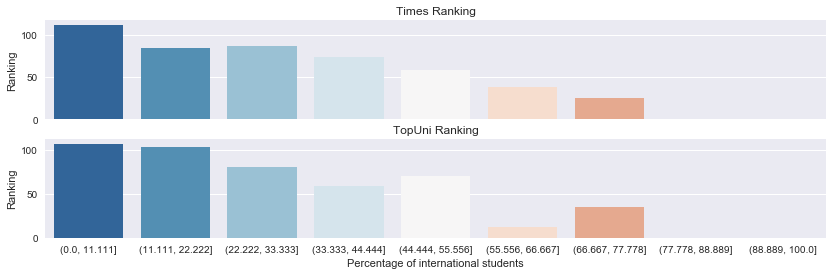

In [69]:
df.index = df.index.values.astype(str)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 4), sharex=True)

sns.barplot(df.index, df.rank_times.values, palette="RdBu_r", ax=ax1)
ax1.set_ylabel("Ranking")
ax1.set_title('Times Ranking')

sns.barplot(df.index, df.rank_topUni.values, palette="RdBu_r", ax=ax2)
ax2.set_ylabel("Ranking")
ax2.set_xlabel("Percentage of international students")
ax2.set_title("TopUni Ranking")

This graph clearly shows that the highest the international percentage of the school the best is the school's ranking for both rankings.

### 5 - Ranking according to both <a class="anchor" id="5"></a>

Our startegy is to sum the two different rankings, a small value of the sum will indicate that the school is well ranked in both while a high value will indicate that the school is either badly ranked in one of them or not so well ranked in both. It will indeed reflect how well it is ranked by both rankings. ** Even-though the README stated that we should take the website order in case of tie, this decision made little sense to us, therefore we decided to not follow this policy and to keep ties because tied ranking mean similar schools. **
* We first sum the two ranks
* Then we transform that into a ranking using a dictionnary to keep the ties

In [70]:
merged_df['sum_rank'] = pd.to_numeric(merged_df['rank_topUni'])+pd.to_numeric(merged_df['rank_times'])
merged_df = merged_df.sort_values('sum_rank')

# Mapping sum to ranking 
ranking_map = {}
for (i,v) in enumerate(merged_df['sum_rank'].unique()):
    ranking_map[v] = i+1
merged_df['merged_ranking'] = merged_df['sum_rank'].map(lambda x : ranking_map[x])

# Keeping only the interesting columns
total_ranking = merged_df.reset_index()[['merged_ranking',
                                         'school_name',
                                         'total_staff',
                                         'international_staff',
                                         'total_student',
                                         'international_student',
                                         'country','region']].set_index('merged_ranking')
total_ranking.head()

,school_name,total_staff,international_staff,total_student,international_student,country,region
merged_ranking,,,,,,,
1,stanford university,3199.0,2042.0,15861.5,3548.5,United States,North America
2,massachusetts institute of technology,2133.5,1679.0,11122.0,3758.5,United States,North America
3,california institute of technology,646.5,350.0,2232.0,621.5,United States,North America
3,university of cambridge,3588.5,2278.0,18579.5,6567.5,United Kingdom,Europe
3,university of oxford,4286.0,2964.0,20064.5,7554.0,United Kingdom,Europe
